In [1]:
import os,sys,time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings("ignore")

datacube = datacube = fits.getdata('../training_data/speccube_10000_high1000.fits', 1)
print(datacube.names)

wave_grid = np.linspace(np.log10(1200), np.log10(7200), 1000)

fig, ax = plt.subplots(2,2, figsize=(12, 6))
X, Y = np.meshgrid(10**wave_grid, np.arange(200))
Z = np.vstack([np.log10(datacube.SPEC[600:800, :])])
ax[0, 0].pcolor(X, Y, Z, cmap='plasma')
ax[0, 0].set_ylabel('200 samples for review')

flux_projection = np.sum(datacube.SPEC, axis=0)/np.sum((datacube.SPEC != 0), axis=0)
ax[1, 0].plot(10**wave_grid, flux_projection)
ax[1, 0].set_xlim(1200, 7200)
ax[1, 0].set_xlabel('Rest-frame wavelength')
ax[1, 0].set_ylabel('Mean spectrum')

ax[0, 1].step(10**wave_grid, np.sum((datacube.SPEC != 0), axis=0), where='mid', label='All (10k)')
ax[0, 1].step(10**wave_grid, np.sum((datacube.SPEC[:8000, :] != 0), axis=0), where='mid', label='Train (8k)')
ax[0, 1].set_xlim(1200, 7200)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Rest-frame wavelength')
ax[0, 1].set_ylabel('Number of samples')

ax[1, 1].set_visible(False)

datacube = fits.getdata('../training_data/speccube_10000_high1000.fits', 1)
print(datacube.names)
nsamp_train = 8000
nsamp_valid = 1000
nsamp_test = 1000

X_train = torch.from_numpy(datacube.SPEC[:nsamp_train, :].astype(np.float32))
X_train_err = torch.from_numpy(datacube.ERR[:nsamp_train, :].astype(np.float32))
mask_train = torch.tensor((X_train != 0)&(X_train_err > 0), dtype=torch.float32)
label_train = torch.from_numpy(np.stack([datacube.Z_SYS[:nsamp_train].astype(np.float32), \
                                       #datacube.LOGMBH[:nsamp_train].astype(np.float32), \
                                       ]).T)

X_valid = torch.from_numpy(datacube.SPEC[nsamp_train:nsamp_train+nsamp_valid, :].astype(np.float32))
X_valid_err = torch.from_numpy(datacube.ERR[nsamp_train:nsamp_train+nsamp_valid, :].astype(np.float32))
mask_valid = torch.tensor((X_valid != 0)&(X_valid_err > 0), dtype=torch.float32)
label_valid = torch.from_numpy(np.stack([datacube.Z_SYS[nsamp_train:nsamp_train+nsamp_valid].astype(np.float32), \
                                        #datacube.LOGMBH[nsamp_train:nsamp_train+nsamp_valid].astype(np.float32), \
                                        ]).T)

X_test_all = torch.from_numpy(datacube.SPEC[nsamp_train+nsamp_valid:, :].astype(np.float32))
X_test_err = torch.from_numpy(datacube.ERR[nsamp_train+nsamp_valid:, :].astype(np.float32))
label_test = torch.from_numpy(np.stack([datacube.Z_SYS[nsamp_train+nsamp_valid:].astype(np.float32), \
                                        #datacube.LOGMBH[nsamp_train:].astype(np.float32), \
                                        ]).T)

In [2]:
def read_datacube(fn):
    datacube = pd.read_csv(fn)
    flux_columns = [f'flux_{i}' for i in range(1000)]
    err_columns = [f'err_{i}' for i in range(1000)]

    flux_data = datacube[flux_columns].values
    err_data = datacube[err_columns].values
    params = datacube[['PLATE', 'MJD', 'FIBERID', 'OBJID', 'Z_SYS', 
                       'LOGMBH', 'LOGLBOL', 'LOGLEDD_RATIO']]
    return flux_data, err_data, params

In [3]:
# Read in the data
datacube = read_datacube('../training_data/DR16_speccube.dat')

In [4]:
import torch
import torch.nn as nn

sys.path.append('./scripts/')
from modules import *

(array([1.8306e+04, 6.1578e+04, 7.7527e+04, 6.5418e+04, 4.7533e+04,
        1.5747e+04, 4.3500e+03, 7.5500e+02, 6.2000e+01, 7.0000e+00]),
 array([3.94872197e-04, 5.41613439e-01, 1.08283201e+00, 1.62405057e+00,
        2.16526914e+00, 2.70648770e+00, 3.24770627e+00, 3.78892484e+00,
        4.33014340e+00, 4.87136197e+00, 5.41258054e+00]),
 <BarContainer object of 10 artists>)

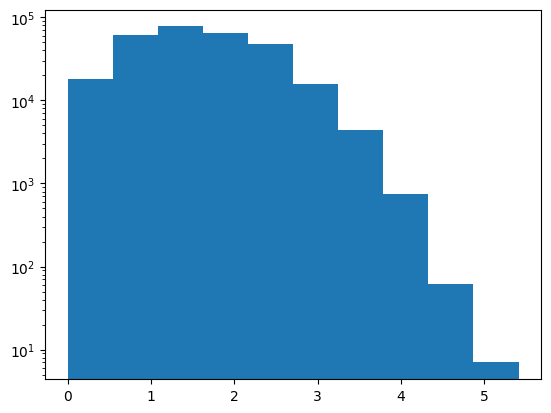

In [5]:
plt.hist(datacube[2].Z_SYS.values, log=True)

In [6]:
nsamp_train = 8000
nsamp_valid = 1000
nsamp_test = 1000
nsamp_total = nsamp_train + nsamp_valid + nsamp_test

ind_train = np.random.choice(len(datacube[0]), nsamp_train, replace=False)
"""
ind_train = np.array([])
for zi in range(4):
    ind_z_range = np.where((datacube[2].Z_SYS.values>zi)&\
                           (datacube[2].Z_SYS.values<zi+1))[0]
    ind_train = np.append(ind_train, np.random.choice(ind_z_range, nsamp_train//4, replace=False))
"""
all_index_arr = np.arange(len(datacube[0]))
ind_mask_train = np.isin(all_index_arr, ind_train)
ind_valid = np.random.choice(all_index_arr[ind_mask_train], nsamp_valid, replace=False)
ind_test = np.random.choice(all_index_arr[~ind_mask_train], nsamp_test, replace=False)

In [7]:
X_train = torch.from_numpy(datacube[0][ind_train, :].astype(np.float32))
X_train_err = torch.from_numpy(datacube[1][ind_train, :].astype(np.float32))
mask_train = torch.tensor((X_train != 0)&(X_train_err > 0), dtype=torch.float32)
label_train = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_train].astype(np.float32), \
                                       ]).T)

X_valid = torch.from_numpy(datacube[0][ind_valid, :].astype(np.float32))
X_valid_err = torch.from_numpy(datacube[1][ind_valid, :].astype(np.float32))
mask_valid = torch.tensor((X_valid != 0)&(X_valid_err > 0), dtype=torch.float32)
label_valid = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_valid].astype(np.float32), \
                                        ]).T)

X_test_all = torch.from_numpy(datacube[0][ind_test, :].astype(np.float32))
X_test_err = torch.from_numpy(datacube[1][ind_test, :].astype(np.float32))
label_test = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_test].astype(np.float32), \
                                        ]).T)

X_train_missed = generate_missing_pixel(X_train, missing_rate=0.2)
mask_train_missed = torch.tensor((X_train_missed != 0)&(X_train_err>0), dtype=torch.float32)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(10**wave_grid, X_train[0])
ax.plot(10**wave_grid, X_train_err[0])
ax.plot(10**wave_grid[mask_train[0].numpy()!=0], 40*np.ones(mask_train[0].sum().numpy().astype(int)), color='gray', ls='', marker='o')

ax.plot(10**wave_grid, X_train_missed[0], ls='--')
ax.plot(10**wave_grid[mask_train_missed[0].numpy()!=0], 20*np.ones(mask_train_missed[0].sum().numpy().astype(int)), color='g', ls='', marker='o')


(array([ 44., 200., 238., 220., 190.,  75.,  26.,   5.,   1.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

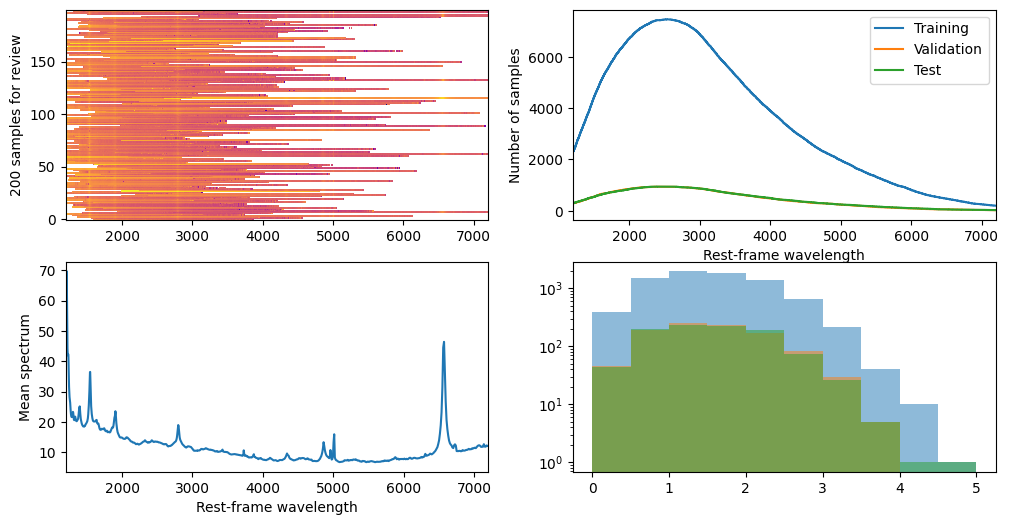

In [8]:
wave_grid = np.linspace(np.log10(1200), np.log10(7200), 1000)

fig, ax = plt.subplots(2,2, figsize=(12, 6))
X, Y = np.meshgrid(10**wave_grid, np.arange(200))
Z = np.vstack([np.log10(X_train[:200, :])])
ax[0, 0].pcolor(X, Y, Z, cmap='plasma')
ax[0, 0].set_ylabel('200 samples for review')

flux_projection = np.sum(X_train.detach().numpy(), axis=0)/np.sum((X_train.detach().numpy() != 0), axis=0)
ax[1, 0].plot(10**wave_grid, flux_projection)
ax[1, 0].set_xlim(1200, 7200)
ax[1, 0].set_xlabel('Rest-frame wavelength')
ax[1, 0].set_ylabel('Mean spectrum')

ax[0, 1].step(10**wave_grid, np.sum((X_train.detach().numpy() != 0), axis=0), where='mid', label='Training')
ax[0, 1].step(10**wave_grid, np.sum((X_valid.detach().numpy() != 0), axis=0), where='mid', label='Validation')
ax[0, 1].step(10**wave_grid, np.sum((X_test_all.detach().numpy() != 0), axis=0), where='mid', label='Test')
ax[0, 1].set_xlim(1200, 7200)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Rest-frame wavelength')
ax[0, 1].set_ylabel('Number of samples')

ax[1, 1].hist(datacube[2].Z_SYS.values[ind_train], bins=10, range=(0, 5), alpha=0.5, label='Training', log=True)
ax[1, 1].hist(datacube[2].Z_SYS.values[ind_valid], bins=10, range=(0, 5), alpha=0.5, label='Validation', log=True) 
ax[1, 1].hist(datacube[2].Z_SYS.values[ind_test], bins=10, range=(0, 5), alpha=0.5, label='Test', log=True)

In [9]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
print(torch.mps.is_available())

True
True
True


In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)
nsamp = len(X_train)
npix = X_train.shape[1]
nlabel = label_train.shape[1]

model = SpecTransformer(input_size=npix, device=device, label_size=nlabel, \
                         dropout = 0.1)
model.to(device)

mps


SpecTransformer(
  (encoder): Encoder(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNor

In [20]:
nepoch = 100
batch_size = 32
loss_epoch = []
loss_valid_epoch = []
best_loss = 1e6

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
for epoch in range(nepoch):
    t0 = time.time()
    model.train()
    for i in range(0, nsamp_train-batch_size, batch_size):
        optimizer.zero_grad()
        X_batch = X_train[i:i+batch_size]
        X_batch_err = X_train_err[i:i+batch_size]
        mask_batch = mask_train[i:i+batch_size]
        label_batch = label_train[i:i+batch_size]
        #Y_pred = model(X_batch)
        #loss = masked_mse_loss(X_batch, Y_pred, mask_batch)
        #loss = masked_gaussian_likelihood(X_batch, Y_pred[0], mask_batch, X_batch_err)

        X_batch_missed = generate_missing_pixel(X_batch, missing_rate=np.random.uniform(0, 0.5, 1))
        mask_batch_missed = torch.tensor((X_batch_missed != 0)&(X_batch_err>0), dtype=torch.float32)    
        Y_pred, _ = model(X_batch_missed.to(device), label_batch.to(device))
        loss = masked_gaussian_likelihood(X_batch.to(device), Y_pred.to(device), mask_batch.to(device), X_batch_err.to(device))
        
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.item())

    model.eval()
    with torch.no_grad():
        Y_valid, _ = model(X_valid.to(device), label_valid.to(device))
        loss_valid = masked_gaussian_likelihood(X_valid.to(device), Y_valid.to(device), mask_valid.to(device), X_valid_err.to(device))
    loss_valid_epoch.append(loss_valid.item())
    print(f"Epoch {epoch+1}, loss={loss.item():.2f}, valid_loss={loss_valid.item():.2f}, time={time.time()-t0:.2f}s")

    if loss_valid < best_loss:
        best_loss = loss_valid
        torch.save(model.state_dict(), './saved_model/SpecTransformer_Dec04_mps')
        print(f'Model saved (epoch={epoch+1})')

Epoch 1, loss=329.18, valid_loss=347.86, time=9.37s
Model saved (epoch=1)
Epoch 2, loss=246.92, valid_loss=265.63, time=9.03s
Model saved (epoch=2)
Epoch 3, loss=219.15, valid_loss=231.20, time=8.79s
Model saved (epoch=3)
Epoch 4, loss=211.72, valid_loss=218.82, time=8.84s
Model saved (epoch=4)
Epoch 5, loss=207.13, valid_loss=212.47, time=8.78s
Model saved (epoch=5)
Epoch 6, loss=200.08, valid_loss=204.07, time=8.83s
Model saved (epoch=6)
Epoch 7, loss=193.14, valid_loss=195.64, time=8.80s
Model saved (epoch=7)
Epoch 8, loss=186.45, valid_loss=188.17, time=8.81s
Model saved (epoch=8)
Epoch 9, loss=180.17, valid_loss=181.24, time=8.76s
Model saved (epoch=9)
Epoch 10, loss=174.11, valid_loss=175.53, time=9.38s
Model saved (epoch=10)
Epoch 11, loss=169.24, valid_loss=169.03, time=8.92s
Model saved (epoch=11)
Epoch 12, loss=163.29, valid_loss=163.32, time=9.03s
Model saved (epoch=12)
Epoch 13, loss=160.24, valid_loss=156.91, time=8.88s
Model saved (epoch=13)
Epoch 14, loss=152.85, valid_l

nepoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(nepoch):
    t0 = time.time()
    model.train()
    for i in range(0, nsamp_train-batch_size, batch_size):
        optimizer.zero_grad()
        X_batch = X_train[i:i+batch_size]
        X_batch_err = X_train_err[i:i+batch_size]
        mask_batch = mask_train[i:i+batch_size]
        label_batch = label_train[i:i+batch_size]
        #Y_pred = model(X_batch)
        #loss = masked_mse_loss(X_batch, Y_pred, mask_batch)
        #loss = masked_gaussian_likelihood(X_batch, Y_pred[0], mask_batch, X_batch_err)

        X_batch_missed = generate_missing_pixel(X_batch, missing_rate=np.random.uniform(0, 0.5, 1))
        mask_batch_missed = torch.tensor((X_batch_missed != 0)&(X_batch_err>0), dtype=torch.float32)    
        Y_pred, _ = model(X_batch_missed.to(device), label_batch.to(device))
        loss = masked_gaussian_likelihood(X_batch.to(device), Y_pred.to(device), mask_batch.to(device), X_batch_err.to(device))
        
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.item())

    model.eval()
    with torch.no_grad():
        Y_valid, _ = model(X_valid.to(device), label_valid.to(device))
        loss_valid = masked_gaussian_likelihood(X_valid.to(device), Y_valid.to(device), mask_valid.to(device), X_valid_err.to(device))
    loss_valid_epoch.append(loss_valid.item())
    print(f"Epoch {epoch+1}, loss={loss.item():.2f}, valid_loss={loss_valid.item():.2f}, time={time.time()-t0:.2f}s")

    if loss_valid < best_loss:
        best_loss = loss_valid
        torch.save(model.state_dict(), './saved_model/SpecTransformer_Dec04_mps')
        print(f'Model saved (epoch={epoch+1})')

Text(0.5, 0, 'Epoch')

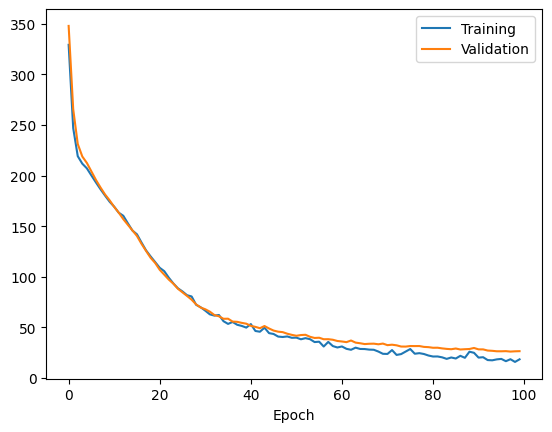

In [21]:
plt.plot(loss_epoch, label='Training')
plt.plot(loss_valid_epoch, label='Validation')
plt.legend()
plt.xlabel('Epoch')

In [22]:
best_model = SpecTransformer(input_size=npix, device=device, label_size=nlabel, \
                            dropout = 0.1)
best_model.load_state_dict(torch.load('./saved_model/SpecTransformer_Dec04_mps'))
best_model.to(device)

SpecTransformer(
  (encoder): Encoder(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNor

In [23]:
best_model.eval()

ind_test_plot = np.sort(np.random.choice(1000, 100, replace=False))

X_test_missed1 = generate_missing_pixel(X_test_all, missing_rate=0.2)
mask_test_missed1 = torch.tensor((X_test_missed1 != 0)&(X_test_err>0), dtype=torch.float32)
X_test_missed2 = generate_missing_pixel(X_test_all, missing_rate=0.4)
mask_test_missed2 = torch.tensor((X_test_missed2 != 0)&(X_test_err>0), dtype=torch.float32)

with torch.no_grad():
    Y_reconstructed_missed1, label_pred_all = best_model(X_test_missed1.to(device), label_test.to(device))
    Y_reconstructed_missed2, label_pred_all = best_model(X_test_missed2.to(device), label_test.to(device))

with PdfPages('./figs/test3_mps.pdf') as pdf:
    for i in ind_test_plot:
        Y_pred_missed1 = Y_reconstructed_missed1[i]
        Y_pred_missed2 = Y_reconstructed_missed2[i]
        loss_missed1 = masked_gaussian_likelihood(X_test_all[i].to(device), Y_pred_missed1, mask_test_missed1[i].to(device), X_test_err[i].to(device))
        loss_missed2 = masked_gaussian_likelihood(X_test_all[i].to(device), Y_pred_missed2, mask_test_missed2[i].to(device), X_test_err[i].to(device))

        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.set_position([0.08, 0.15, 0.85, 0.8])

        ax.plot(10**wave_grid, flux_projection, c='silver', alpha=0.5, label='Mean spectrum', zorder=-1)
        ax.plot(10**wave_grid, X_test_all[i], c='k', label='Original spectrum', zorder=1)
        ax.plot(10**wave_grid, X_test_err[i], c='k', ls=':', label='Error', zorder=1)

        ax.fill_between(10**wave_grid, X_test_all[i], X_test_missed1[i], lw=0, \
                        color='skyblue', alpha=0.5, label='Missing pixels (20%)', zorder=1)
        ax.plot(10**wave_grid, Y_pred_missed1.cpu().detach().numpy(), \
                c='royalblue', label='Reconstructed spectrum (missing 20%)', lw=0.5, zorder=2, alpha=0.9)
        
        ax.fill_between(10**wave_grid, X_test_all[i], X_test_missed2[i], lw=0, \
                        color='orange', alpha=0.5, label='Missing pixels (40%)', zorder=1)
        ax.plot(10**wave_grid, Y_pred_missed2.cpu().detach().numpy(), \
                c='darkorange', label='Reconstructed spectrum (missing 40%)', lw=0.5, zorder=2, alpha=0.9)
                
        ax.legend()
        ax.text(0.98, 0.98, r"train#%d, z=%.2f"%(i, label_test[i]), \
                ha='right', va='top', transform=ax.transAxes)
        ax.text(0.98, 0.90, r"loss$_{20}$=%.2f, loss$_{40}$=%.2f"%(np.around(loss_missed1.cpu(),2), np.around(loss_missed2.cpu(),2),), \
                ha='right', va='top', transform=ax.transAxes)
        
        ax.axvline(1215.67, ls=':', c='grey', lw=0.5)
        ax.axvline(1549.06, ls=':', c='grey', lw=0.5)
        ax.axvline(1908.73, ls=':', c='grey', lw=0.5)
        ax.axvline(2798.75, ls=':', c='grey', lw=0.5)
        ax.axvline(4862.68, ls=':', c='grey', lw=0.5)
        ax.axvline(6564.61, ls=':', c='grey', lw=0.5)
        ax.set_xlabel('Rest-frame wavelength')
        ax.set_ylabel('Flux')
        ax.set_xlim(1200, 7200)
        pdf.savefig(fig)
        plt.close()
